In [1]:
import os
import pandas as pd
import numpy as np

import qamlzim as qamlz
import json
from pickle import dump, load

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import itertools


# Dataset

These cuts are already applied on the input dataset:
* 20.000 <= glb_PT <= 100.000
* 2.2 <= glb_Eta <= 4.2
* bb condition: glb_MC_Jet_EfB >= 0.6
* cc condition: glb_MC_Jet_EfD >= 0.4
* vtx_m != 0


In [2]:
# load dataset
input_data = pd.read_hdf("Dijet_bbcc_SVGCTMC.hdf")

In [3]:
# split train e test dataset
from sklearn.model_selection import train_test_split

dataTrain, dataTest = train_test_split(input_data, random_state=42)
dataTrain.reset_index(inplace=True, drop=True)
dataTest.reset_index(inplace=True, drop=True)


In [4]:
print("In the training dataset there are\n \t %d bb events \n \t %d cc events \n total of %d events"%(\
    dataTrain[dataTrain.label==0].shape[0], dataTrain[dataTrain.label==1].shape[0], dataTrain.shape[0]))
print("In the test dataset there are\n \t %d bb events \n \t %d cc events \n total of %d events"%(\
    dataTest[dataTest.label==0].shape[0], dataTest[dataTest.label==1].shape[0], dataTest.shape[0]))

In the training dataset there are
 	 2698509 bb events 
 	 922736 cc events 
 total of 3621245 events
In the test dataset there are
 	 898712 bb events 
 	 308370 cc events 
 total of 1207082 events


In [5]:
# Select the input features

target_col = 'label'

# define the features for each categories
vtxcol = ['vtx_fdrMin', 'vtx_ptSvrJet', 'vtx_nTrk', 'vtx_nTrkJet', 'vtx_drSvrJet',\
          'vtx_absQSum', 'vtx_m', 'vtx_mCor', 'vtx_fdChi2', 'vtx_ipChi2Sum',\
          'vtx_tau', 'vtx_z', 'vtx_pt' ]
glbcol = ['glb_PX', 'glb_PY', 'glb_PZ', 'glb_PE', 'glb_M', 'glb_PT',\
          'glb_P', 'glb_Eta', 'glb_Phi', 'glb_NPartChg', 'glb_NPartNtr']


features_cols = vtxcol + glbcol

## Preprocessing input data

It is useful to prescale data to help the training phase

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler

In [7]:
def scale_dataset(data, scaler = False, scaler2 = False, train = True):
    '''
       Function to rescale the training/test data, if (train==False) applies only transformation
       Arguments: the data and the scaler(s)
       Returns:
            - the rescaled data
            - the fitted scaler(s)
    '''
    if scaler != None:
        if train is True:
            scaler.fit(data)
            data = scaler.transform(data)
            if scaler2 != None:
                scaler2.fit(data)
                data = scaler2.transform(data)
        else: # test behaviour
            data = scaler.transform(data)
            if scaler2 != None:
                data = scaler2.transform(data)
    return data, scaler, scaler2


In [8]:
balanced = True

if balanced:
    df_for_training_grouped = dataTrain.groupby(target_col)
    df_for_training_grouped.groups.values()
    frames_of_groups = [x.sample(df_for_training_grouped.size().min()) for y, x in df_for_training_grouped]
    bdf = pd.concat(frames_of_groups)
    bdf = bdf.sample(frac=1, random_state=42)
    trainSet = bdf[features_cols]
    ytrain = bdf[target_col]*2-1
else:
    ## Define training dataset
    trainSet = dataTrain[features_cols]
    # maps labels from 0,1 --> -1,1 (spin)
    ytrain = dataTrain[target_col]*2-1

## Define test dataset
Xtest = dataTest[features_cols]
ytest = dataTest[target_col]

In [9]:
scaler           = PowerTransformer()
scaler2          = None #MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))

Xtrain_sc, scaler, scaler2 = scale_dataset(trainSet, scaler, scaler2, train=True)
# scaler(s) are only applied for test set
Xtest_sc, _, _ = scale_dataset(Xtest, scaler, scaler2, train=False)

KeyboardInterrupt: 

# Quantum Annealing

In [10]:
AUGMENT_SIZE = 6
AUGMENT_OFFSET = 0.0225 / AUGMENT_SIZE
#AUGMENT_OFFSET = 0.0435 / AUGMENT_SIZE
CUTOFF = 95

In [11]:
def make_results_json(fail_flag=""):
    filename = "%sanneal_results-%s.json" % (fail_flag, model.start_time)
    destdir = "qamlz_results"
    filepath = os.path.join(destdir, filename)
    if not os.path.exists(destdir):
        os.makedirs(destdir)
    modconf = {}
    modconf["start_time"] = model.start_time
    modconf["result"] = model.anneal_results
    modconf["bestiter"] = [key[:-4] for key, value in model.anneal_results.items() if value == np.amax(list(model.anneal_results.values()))][0]
    for varn in ["n_iterations", 'zoom_factor', 'anneal_time', 'fix_vars', 'cutoff_percentile']:
      modconf[varn] = model.config.__dict__[varn]
    for varn in ['flip_probs']:
      modconf[varn] = model.config.__dict__[varn].tolist()
    for varn in ['train_size', 'fidelity', 'fidelity_offset']:
      modconf[varn] = model.env.__dict__[varn]
    modconf['features'] = features_cols
    modconf['target'] = target_col
    json.dump(modconf, open(filepath, "w"), indent=4)
    return filename

def make_mus_files(scaler=None, scaler2=None, fail_flag=""):
    mus_filenames = []
    mus_destdir = os.path.join("weights/%s" % model.start_time)
    for k, v in model.mus_dict.items():
        mus_filename = fail_flag + k
        mus_filenames.append(mus_filename)
        mus_filepath = os.path.join(mus_destdir, mus_filename)
        if not os.path.exists(mus_destdir):
            os.makedirs(mus_destdir)
        np.save(mus_filepath, v)
    if scaler != None:
        dump(scaler, open('%s/scaler.pkl'%mus_destdir, 'wb'))
    if scaler2 != None:
        dump(scaler2, open('%s/scaler2.pkl'%mus_destdir, 'wb'))
    return mus_destdir, mus_filenames


In [12]:
def load_json(timestamp, failnote=""):
  file_found = False
  while not file_found:
    try:
      filename = "qamlz_results/%sanneal_results-%s.json" % (failnote, timestamp)
      file_found = True
    except FileNotFoundError:
      if failnote == "":
        failnote = "FAILED__"
        continue
      elif failnote == "FAILED__":
        print("File does not exist")
        sys.exit(1)
  print("Open %s..."%filename)
  return json.load(open(filename,))


In [13]:
def create_augmented_data(data, conf):
  offset = conf["fidelity_offset"]
  scale = conf["fidelity"]
  n_samples = len(data)
  n_classifiers = data.shape[1]
  predictions = np.zeros((n_classifiers * scale, n_samples))
  data = np.transpose(data)
  for i in range(n_classifiers):
    for j in range(scale):
       predictions[i * scale + j] = np.sign(
         data[i] + (j - scale // 2) * offset
         ) / (n_classifiers * scale)
  return predictions


In [14]:
def ensemble(predictions, weights):
    n_classifiers = len(weights)
    return np.dot(predictions.T, weights)

def bestacc(data):
  vmax=0
  imax=0
  lim = min(data['pred'])
  prange = max(data['pred']) - lim
  for i in range(100):
    lim += prange/100
    testClasses =  np.array(data['pred'].ravel() > lim, dtype='int64')
    nauc = accuracy_score(data['labels'], testClasses)
    if nauc > vmax:
      vmax = nauc
      imax = lim
  return imax, vmax

def test(modelWeight, data):
    timestamp = modelWeight.split("__")[-1]    
    conf = load_json(timestamp)
    augdata = create_augmented_data(data["features"], conf)
    excited_weights = np.load("weights/%s/%s.npy"%(timestamp, modelWeight))
    pred = ensemble(augdata, excited_weights[0])
    data['pred'] = (pred+1)/2
    imax, vmax = bestacc(data)
    print("Best accuracy for thr = %.3f: %.3f "%(imax, vmax))
    data["classes"] = np.array(data['pred'].ravel() > imax, dtype='int64')
    return data


In [15]:
url = "https://cloud.dwavesys.com/sapi/"
token = "DEV-56abefe72745602901e56e161c2fd98b0cd06505"

: 

In [16]:
train_sizes = [Xtrain_sc.shape[0]]
for train_size in train_sizes:
    print("train_size = %d" % train_size)
    env = qamlz.TrainEnv(
        Xtrain_sc[:train_size],
        ytrain.iloc[:train_size],
        url,
        token,
        fidelity=AUGMENT_SIZE,
        dwave_topology="pegasus"
    )
    env.fidelity_offset = AUGMENT_OFFSET
    config = qamlz.ModelConfig()
    config.cutoff_percentile = CUTOFF
    #config.encode_vars = None
    config.fix_vars = True
    '''
    # to change interation number uncomment the following lines
    config.n_iterations = 15
    config.flip_probs = np.linspace(0.2, 0.01, num=config.n_iterations)
    config.strengths = [3.0, 1.0, 0.5, 0.2] + [0.1] * (config.n_iterations - 4)        
    config.max_states = [16, 4] + [1] * (config.n_iterations - 2)
    '''
    model = qamlz.Model(config, env)
    try:
        model.train()
    except Exception as e:
        print(e)
        make_results_json("FAIL")
        mus_dir, mus_filenames = make_mus_files(fail_flag="FAIL")
        raise e
    make_results_json()
    mus_dir, mus_filenames = make_mus_files(scaler=scaler, scaler2=scaler2)
    data={}
    data['features'] = Xtest_sc
    data['labels'] = ytest.values
    res = test(mus_filenames[-1], data)

train_size = 1845472


/home/jacopo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


# Useful functions to plot results

In [19]:
def calc_auc(y_score, y_test):
    '''
    Function to calculate the AUC
    Returns:
        - Increasing false positive rates
        - Increasing true positive rates
        - Ares Under the Curve
    '''
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = label_binarize(y_test,classes=[-1, 1])
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def plot_roc(fpr, tpr, roc_auc, label_m, ax=None, **plt_kwargs):
    '''
    Function to plot the ROC curve and return the graph
    '''
    if ax is None:
        ax = plt.gca()
    lw = 2
    ax.plot(
        fpr[0],
        tpr[0],
        lw=lw,
        label=label_m+"(AUC = %0.3f)" % roc_auc[0],
    )
    ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver operating characteristic example")
    ax.legend(loc="lower right")
    return ax

def plot_dist(sol, labels):
    '''
    Function to plot the distributions
    '''
    plt.figure();
    plt.hist(sol[labels==0],bins=np.linspace(0,1,100),
             histtype='step',color='midnightblue',label='bb');
    # make the plot readable
    plt.hist(sol[labels==1],bins=np.linspace(0,1,100),
             histtype='step',color='firebrick',label='cc')
    plt.xlabel('Prediction',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.legend(frameon=False)
    plt.show()

def confmatrix(cm, classes, normalize=False,
                title='Confusion matrix',
                cmap=plt.cm.RdYlGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / (100*cm.sum(axis=1)[:, np.newaxis])
    plt.rcParams["axes.grid"] = False
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    if normalize:
        fmt = '.2%'
        cm = 100*cm
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
          horizontalalignment="center",
          color="black" if ( cm[i, j] > cm.max()/4.) and (cm[i,j] < 3*cm.max()/4.)  else "white")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



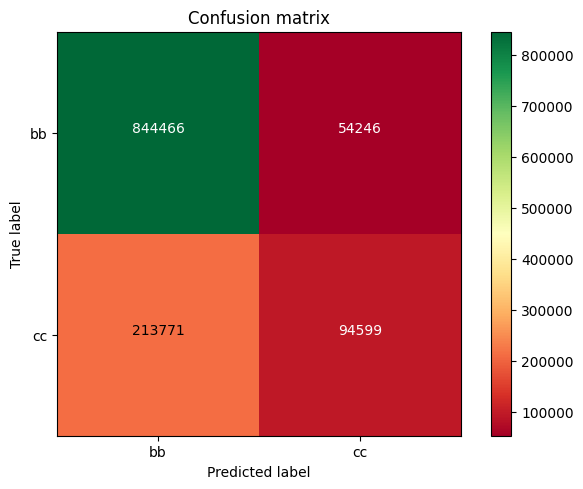


              precision    recall  f1-score   support

          bb       0.80      0.94      0.86    898712
          cc       0.64      0.31      0.41    308370

    accuracy                           0.78   1207082
   macro avg       0.72      0.62      0.64   1207082
weighted avg       0.76      0.78      0.75   1207082



In [20]:
# Confusion matrix for test
confmatrix(confusion_matrix(res['labels'], res['classes']), ['bb', 'cc'])
print("\n%s"%classification_report(res['labels'], res['classes'], target_names=['bb', 'cc']))

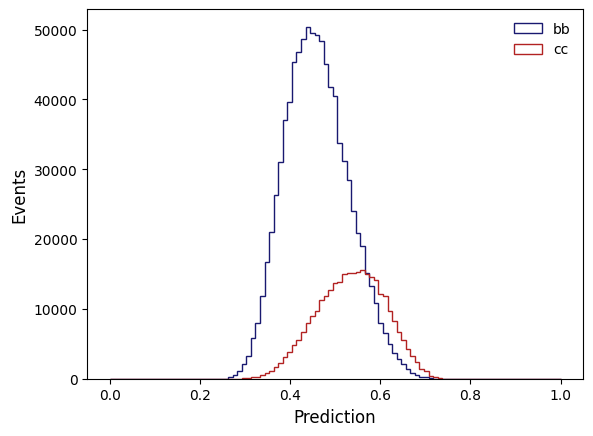

In [21]:
plot_dist(res['pred'], res["labels"])

# Deep Neural Network (DNN)

In [22]:
# keras, classical ML packages
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers     import Dense, Dropout, Flatten, LSTM, Conv2D, Conv1D
from tensorflow.keras.models     import Sequential
from tensorflow.keras.callbacks  import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

2024-08-19 16:19:08.802246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
def DNN_model(inputsize, idn, nclasses=1, kinit='normal', btcMom=0.6, dropRate=0.1):
    '''
    Function to set-up the layers and neurons for the DNN
        - idn: name of the model
    '''
    model = Sequential(name="Model_%s"%idn)
    model.add(Dense(96, kernel_initializer=kinit, activation='relu', name='%s_dense0'%idn, input_dim=inputsize))
    model.add(Dropout(dropRate, name='%s_dropout0'%idn))
    model.add(Dense(96, kernel_initializer=kinit, activation='relu', name='%s_dense1'%idn))
    model.add(Dropout(dropRate, name='%s_dropout1'%idn))
    model.add(Dense(128, kernel_initializer=kinit, activation='relu', name='%s_dense2'%idn))
    model.add(Dropout(dropRate, name='%s_dropout2'%idn))
    model.add(Dense(96, kernel_initializer=kinit, activation='relu', name='%s_dense3'%idn))
    model.add(Dropout(dropRate, name='%s_dropout3'%idn))
    model.add(Dense(96, kernel_initializer=kinit, activation='relu', name='%s_dense4'%idn))
    model.add(Dropout(dropRate, name='%s_dropout4'%idn))
    model.add(Dense(nclasses, activation='sigmoid', kernel_initializer=kinit, name='%s_pred0'%idn))
    return model

In [24]:
def Train_DNN(model, opt, trainData, trainLabel, patience=25, epochs=100, batch=64, modelfile="model.h5", verb=1, cb=True):
    '''
    Function to do a binary classification using DNN
        - cb: use callbacks
        - verb: verbosity level
    '''
    tf.keras.backend.clear_session()
    # compile model 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    # check if the model has been alredy trained
    if os.path.exists(modelfile):
        print("Load previous trained model...")
        model.load_weights(modelfile)
        hist = None
    else:
        checkpointer = ModelCheckpoint(modelfile, verbose=verb, save_best_only=True, save_weights_only=True)
        earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=patience, verbose=verb, mode='auto')
        Xtrain, Xvalid, ytrain, yvalid = train_test_split(trainData, trainLabel, random_state=13)
        if cb:
            hist = model.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch, validation_data=(Xvalid, yvalid), verbose=verb, callbacks=[checkpointer, earlystop])
        else: # do not use callbacks
            hist = model.fit(Xtrain, ytrain, epochs=epochs, batch_size=batch, validation_data=(Xvalid, yvalid), verbose=verb)
            model.save(modelfile, overwrite=True, include_optimizer=False)
    return hist

In [25]:
def Pred_DNN(model, testData, testLabel, modelfile="model.h5", verb=1):
    '''
    Returns predicted probabilities
        - verb: verbosity level
    '''
    if os.path.exists(modelfile):
        model.load_weights(modelfile)
        score = model.evaluate(testData, testLabel, verbose=verb)
        print('Test accuracy: %f'%score[1])
        return model.predict(testData)
    else:
        print("ERROR! Weight file does not exists!")

In [26]:
def Plot_history(hist):
  '''
  Plot Accuracy and loss plots from fit history data
  '''
  plt.figure()
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure()
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')
  plt.show()

In [27]:
scaler         = PowerTransformer()
scaler2          = None

Xtrain_sc, scaler, scaler2 = scale_dataset(trainSet, scaler, scaler2, train=True)
# scaler(s) are only applied for test set
Xtest_sc, _, _ = scale_dataset(Xtest, scaler, scaler2, train=False)

In [28]:
## DNN works with 0/1 labels
if balanced:
    ytrain = bdf.label
else:    
    ytrain = dataTrain.label

In [29]:
### Define the network model
dnn = DNN_model(Xtrain_sc.shape[1], 'DNN')
dnn.summary()

/lhcbdata/miniconda3/alma9/envs/qmlgpu/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Model_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ DNN_dense0 (Dense)              │ (None, 96)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dropout0 (Dropout)          │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dense1 (Dense)              │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dropout1 (Dropout)          │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dense2 (Dense)              │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dropout2 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dense3 (Dense)              │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dropout3 (Dropout)          │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dense4 (Dense)              │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_dropout4 (Dropout)          │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DNN_pred0 (Dense)               │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,921 (179.38 KB)

 Trainable params: 45,921 (179.38 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
### Train the DNN
opt = Adam(learning_rate=0.0001)
patience = 25
epochs = 30
batch = 32
pathmodel = "model.weights.h5"

hist = Train_DNN(dnn, opt, Xtrain_sc, ytrain, patience=patience, epochs=epochs, batch=batch, modelfile=pathmodel)
if hist:
    Plot_history(hist)

Load previous trained model...


/lhcbdata/miniconda3/alma9/envs/qmlgpu/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


37722/37722 ━━━━━━━━━━━━━━━━━━━━ 24s 627us/step - accuracy: 0.8384 - loss: 0.3389
Test accuracy: 0.837798
37722/37722 ━━━━━━━━━━━━━━━━━━━━ 23s 614us/step


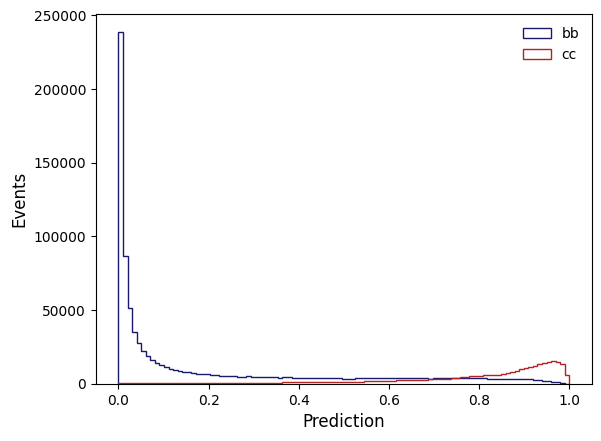

In [31]:
# Prediction distributions: DNN
pred_dnn = Pred_DNN(dnn, Xtest_sc, ytest, modelfile=pathmodel)
plot_dist(pred_dnn,  ytest)

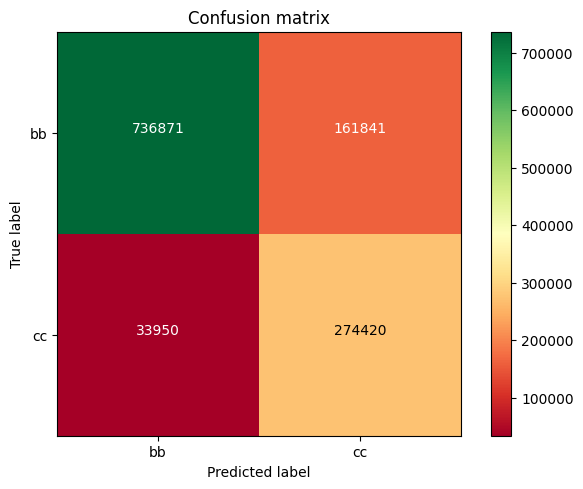


              precision    recall  f1-score   support

          bb       0.96      0.82      0.88    898712
          cc       0.63      0.89      0.74    308370

    accuracy                           0.84   1207082
   macro avg       0.79      0.85      0.81   1207082
weighted avg       0.87      0.84      0.85   1207082



In [32]:
# predicttion => round(prob) i.e. cut 0.5
classes_dnn =  np.array([round(x[0]) for x in pred_dnn], dtype='int64')

# Confusion matrix for test
confmatrix(confusion_matrix(ytest, classes_dnn), ['bb', 'cc'])
print("\n%s"%classification_report(ytest, classes_dnn, target_names=['bb', 'cc']))

# Boosted decision trees (BDT)

In [33]:
import xgboost as xgb

In [34]:
def Train_bdt(X_train, Y_train, ntree=100, eta=0.1, depth=10):
    '''
    Function to do a binary prediction using BDT
    '''
    train = xgb.DMatrix(data=X_train, label=Y_train, missing=-999.0)
    param = {}
    # Booster parameters
    param['eta']              = eta   # learning rate
    param['max_depth']        = depth # maximum depth of a tree
    param['subsample']        = 0.8   # fraction of events to train tree on
    param['colsample_bytree'] = 0.8   # fraction of features to train tree on
    # Learning task parameters
    param['objective']   = 'binary:logistic' # objective function          
    param['eval_metric'] = 'auc'             # METRIC
    param = list(param.items()) 
    # train
    xgb.set_config(verbosity=1)
    booster = xgb.train(param,train,num_boost_round=ntree)
    return booster

In [35]:
def Eval_bdt(booster, X_test, Y_test, fea_imp=False):
    '''
    Evaluates a trained bdt
        - fea_imp: plot also the features importance
    '''
    test  = xgb.DMatrix(data=X_test,  label=Y_test,  missing=-999.0)
    # Evaluate
    print(booster.eval(test))
    # Predict
    Y_predict = booster.predict(test)
    print("Accuracy is: %.3f"%accuracy_score(Y_test, Y_predict>0.5))
    if fea_imp:
        # Feature importance
        fig, ax = plt.subplots()
        xgb.plot_importance(booster,ax=ax, grid=False)
    return Y_predict

In [36]:
## DNN works with 0/1 labels
if balanced:
    ytrain = bdf.label
else:    
    ytrain = dataTrain.label

[0]	eval-auc:0.93274311997574388
Accuracy is: 0.844


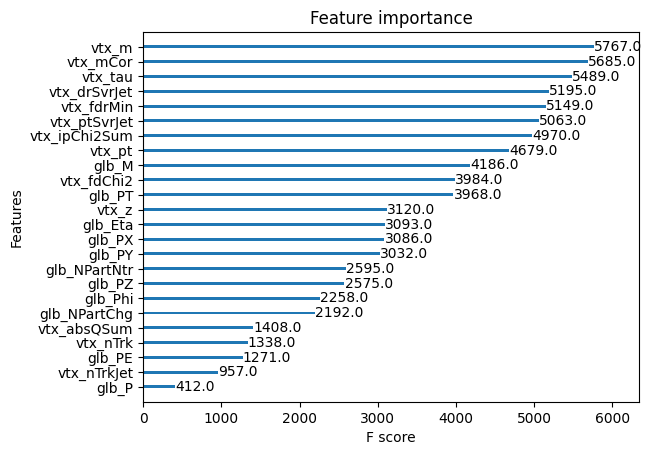

In [37]:
num_trees = 100

bdt = Train_bdt(Xtrain_sc, ytrain, ntree = num_trees)
pred_bdt = Eval_bdt(bdt, pd.DataFrame(Xtest_sc, columns=features_cols), ytest, fea_imp=True)

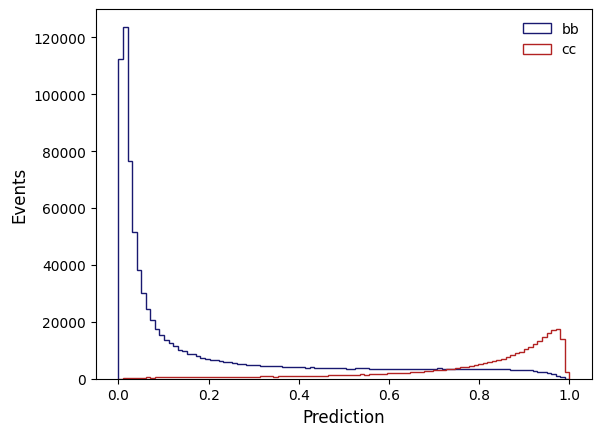

In [38]:
plot_dist(pred_bdt, ytest)

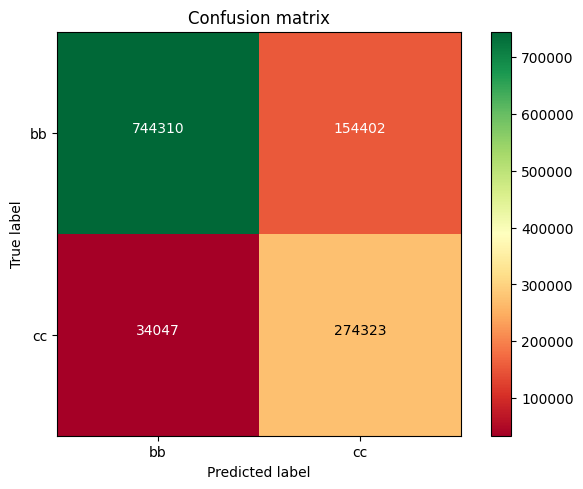


              precision    recall  f1-score   support

          bb       0.96      0.83      0.89    898712
          cx       0.64      0.89      0.74    308370

    accuracy                           0.84   1207082
   macro avg       0.80      0.86      0.82   1207082
weighted avg       0.88      0.84      0.85   1207082



In [39]:
# predicttion => round(prob) i.e. cut 0.5
classes_bdt =  np.array([round(x) for x in pred_bdt], dtype='int64')

# Confusion matrix for test
confmatrix(confusion_matrix(ytest, classes_bdt), ['bb', 'cc'], normalize=False)
print("\n%s"%classification_report(ytest, classes_bdt, target_names=['bb', 'cx']))

# Compare methods

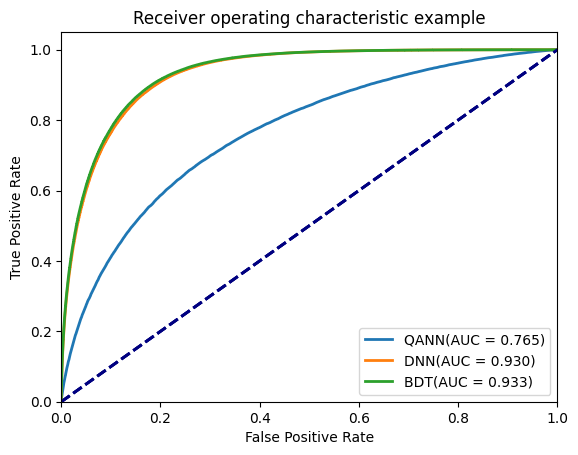

In [40]:
# ROC
ax = plt.gca()
fpr, tpr,roc_auc = calc_auc( res['pred'], res["labels"])
ax = plot_roc(fpr, tpr,roc_auc,'QANN', ax)
fpr, tpr,roc_auc = calc_auc( pred_dnn , ytest)
ax = plot_roc(fpr, tpr,roc_auc,'DNN', ax)
fpr, tpr,roc_auc = calc_auc( pred_bdt , ytest)
ax = plot_roc(fpr, tpr,roc_auc,'BDT',ax)